In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Tokenizers
import jieba
from janome.tokenizer import Tokenizer
from pythainlp.tokenize import word_tokenize as thai_tokenize

In [2]:
# Paths
LANGS_PATH = "./data/raw/langs.txt"
RAW_PATH = "./data/raw/sentences.csv"
PROCESSED_DIR = "./data/processed"
MODEL_PATH = "./models/lang_detect.ftz"

# Limits
MAX_SAMPLES_PER_LANG = 30000

# Ensure dirs
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs("./models", exist_ok=True)


In [3]:
TARGET_LANGS = []
LANG_CODE_TO_NAME = {}

try:
    with open(LANGS_PATH, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() and "," in line:
                code, name = line.strip().split(",", 1)
                code = code.strip()
                name = name.strip()
                TARGET_LANGS.append(code)
                LANG_CODE_TO_NAME[code] = name
except FileNotFoundError:
    print(f"Error: Language list file not found at {LANGS_PATH}")
    raise

print(f"Loaded {len(TARGET_LANGS)} target languages.")


Loaded 137 target languages.


In [4]:
try:
    df = pd.read_csv(RAW_PATH, sep="\t", header=None, names=["id", "lang", "text"], quoting=3)
except FileNotFoundError:
    print(f"Error: File not found at {RAW_PATH}")
    raise

print(f"Loaded {len(df)} rows.")
print(df['lang'].value_counts().head(10))

# Filter to target langs
df = df[df['lang'].isin(TARGET_LANGS)]
print(f"➡️ Filtered rows: {len(df)}")


Loaded 12851487 rows.
lang
eng    1984147
rus    1136949
ita     928445
epo     792549
kab     766828
tur     739366
deu     725029
ber     693360
fra     670427
por     437395
Name: count, dtype: int64
➡️ Filtered rows: 12773227


In [5]:
# Setup janome for Japanese
jpn_tokenizer = Tokenizer()

def tokenize(text, lang):
    try:
        if lang == "cmn":
            return " ".join(jieba.lcut(text))
        elif lang == "jpn":
            return " ".join([t.surface for t in jpn_tokenizer.tokenize(text)])
        elif lang == "tha":
            return " ".join(thai_tokenize(text))
        else:
            return text
    except:
        return text


In [6]:
print("Applying tokenization...")
df["text"] = df.apply(lambda row: tokenize(str(row["text"]), row["lang"]), axis=1)

df_balanced = (
    df.groupby("lang")
    .apply(lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_LANG), random_state=42))
    .reset_index(drop=True)
)

df_balanced['formatted'] = '__label__' + df_balanced['lang'] + ' ' + df_balanced['text']
lines = df_balanced['formatted'].tolist()

random.seed(42)
random.shuffle(lines)

with open(os.path.join(PROCESSED_DIR, "lang_dataset.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(lines))


Applying tokenization...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\leowy\AppData\Local\Temp\jieba.cache
Loading model cost 0.582 seconds.
Prefix dict has been built successfully.
C:\Users\leowy\AppData\Local\Temp\ipykernel_23168\1388613869.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_LANG), random_state=42))


In [7]:
train, testval = train_test_split(lines, test_size=0.3, random_state=42)
test, valid = train_test_split(testval, test_size=1/3, random_state=42)

with open(os.path.join(PROCESSED_DIR, "train.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(train))
with open(os.path.join(PROCESSED_DIR, "test.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(test))
with open(os.path.join(PROCESSED_DIR, "valid.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(valid))

print("✅ Data split complete.")


✅ Data split complete.


In [8]:
TRAIN_PATH = "./data/processed/train.txt"

print("Training FastText language detector...")
model = fasttext.train_supervised(
    input=TRAIN_PATH,
    epoch=10,
    lr=0.3,
    wordNgrams=2,
    minCount=2,
    loss='softmax',
    dim=100,
    verbose=2
)

model.save_model(MODEL_PATH)
print(f"\n✅ Model saved to: {MODEL_PATH}")


Training FastText language detector...

✅ Model saved to: ./models/lang_detect.ftz


In [9]:
def evaluate(dataset_path, name):
    result = model.test(dataset_path)
    print(f"\n📊 Evaluation on {name.upper()} set:")
    print(f"  Samples  : {result[0]}")
    print(f"  Precision: {result[1]:.4f}")
    print(f"  Recall   : {result[2]:.4f}")

evaluate(TRAIN_PATH, "train")
evaluate("./data/processed/test.txt", "test")
evaluate("./data/processed/valid.txt", "validation")



📊 Evaluation on TRAIN set:
  Samples  : 1327351
  Precision: 0.9992
  Recall   : 0.9992

📊 Evaluation on TEST set:
  Samples  : 379244
  Precision: 0.9223
  Recall   : 0.9223

📊 Evaluation on VALIDATION set:
  Samples  : 189622
  Precision: 0.9231
  Recall   : 0.9231



📄 Classification Report:
              precision    recall  f1-score   support

         afr       0.93      0.90      0.92       896
         alt       0.73      0.56      0.63       308
         ara       0.93      0.93      0.93      6009
         arq       0.93      0.66      0.77       512
         arz       0.83      0.52      0.64       317
         asm       0.97      0.95      0.96      2962
         avk       0.94      0.83      0.88       828
         aze       0.92      0.79      0.85      1287
         bel       0.94      0.89      0.91      2900
         ben       0.99      0.97      0.98      3092
         ber       0.81      0.76      0.78      6061
         bre       0.86      0.91      0.88      1585
         bua       0.91      0.64      0.75       224
         bul       0.95      0.92      0.93      5063
         cat       0.95      0.88      0.92      1903
         cbk       0.95      0.88      0.91       645
         ceb       0.84      0.64      0.73       312
 

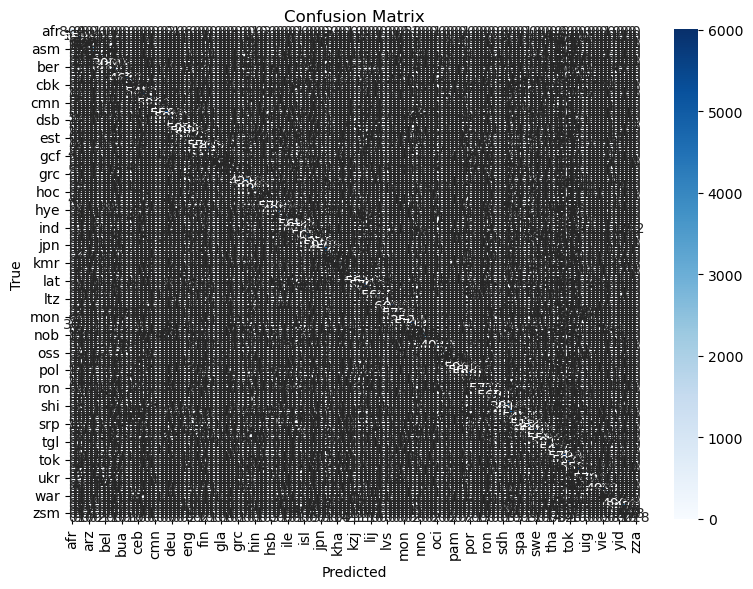

In [10]:
true_labels = []
pred_labels = []

with open("./data/processed/test.txt", "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        label, text = line.strip().split(" ", 1)
        true = label.replace("__label__", "")
        pred = model.predict(text)[0][0].replace("__label__", "")
        true_labels.append(true)
        pred_labels.append(pred)

labels = sorted(list(set(true_labels + pred_labels)))

print("\n📄 Classification Report:")
print(classification_report(true_labels, pred_labels, labels=labels))

cm = confusion_matrix(true_labels, pred_labels, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
